## EEG Emotion Prediction

### Overview

This notebook will create a classifier to predict the emotional state of a subject based on EEG data using a sample dataset with extratcted features.

### Data

The data used for this analysis is from a study on mental state classification conducted with subjects providing EEG data while watching movies. 
<br>
<br>
EEG data was collected using a Muse headband, recording the TP9, AF7, AF8, and TP10 EEG placements using dry electrodes.
<br>
<br>
The scenes of the movie and the anticipated emotional response were categorized under three states: Negative, Neutral, and Positive. These labels will be the output of the classification model.
<br>
<br>
The data was recorded for two subjects for three minutes (in sixty second increments) for 6 different film clips with positive and negative connotations. An additional 6 minutes of resting neutral EEG data was recorded. This leads to a total of 36 minutes of raw EEG data. The signals were then downsampled to 150 Hz which led to a dataset of 324,000 data points. 
<br>
<br>
In its current form, features have been extracted from the dataset using statistical functions, including Mean, Min, Max, Correlation, FFT, and Logarithmic functions. These were calculated using a sliding window of 1 second moved over the raw signals. This feature extraction was done using [this code](https://github.com/jordan-bird/eeg-feature-generation).

#### Data Citation

This EEG data comes from the following sources:

1. J. J. Bird, L. J. Manso, E. P. Ribiero, A. Ekart, and D. R. Faria, “A study on mental state classification using eeg-based brain-machine interface,” in 9th International Conference on Intelligent Systems, IEEE, 2018.

2. J. J. Bird, A. Ekart, C. D. Buckingham, and D. R. Faria, “Mental emotional sentiment classification with an eeg-based brain-machine interface,” in The International Conference on Digital Image and Signal Processing (DISP’19), Springer, 2019.


## Imports and Configuration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import StepLR

In [2]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
# Load data
data_file = './data/emotions.csv'
data = pd.read_csv(data_file)

In [4]:
# Display data
data

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.620,30.3,-356.0,15.60,26.3,1.070,0.411,-15.700,2.060,3.15,...,23.50,20.300,20.300,23.50,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.800,33.1,32.0,25.80,22.8,6.550,1.680,2.880,3.830,-4.82,...,-23.30,-21.800,-21.800,-23.30,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.900,29.4,-416.0,16.70,23.7,79.900,3.360,90.200,89.900,2.03,...,462.00,-233.000,-233.000,462.00,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.900,31.6,-143.0,19.80,24.3,-0.584,-0.284,8.820,2.300,-1.97,...,299.00,-243.000,-243.000,299.00,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.300,31.3,45.2,27.30,24.5,34.800,-5.790,3.060,41.400,5.52,...,12.00,38.100,38.100,12.00,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2127,32.400,32.2,32.2,30.80,23.4,1.640,-2.030,0.647,-0.121,-1.10,...,-21.70,0.218,0.218,-21.70,95.2,-19.90,47.20,47.20,-19.90,NEUTRAL
2128,16.300,31.3,-284.0,14.30,23.9,4.200,1.090,4.460,4.720,6.63,...,594.00,-324.000,-324.000,594.00,-35.5,142.00,-59.80,-59.80,142.00,POSITIVE
2129,-0.547,28.3,-259.0,15.80,26.7,9.080,6.900,12.700,2.030,4.64,...,370.00,-160.000,-160.000,370.00,408.0,-169.00,-10.50,-10.50,-169.00,NEGATIVE
2130,16.800,19.9,-288.0,8.34,26.0,2.460,1.580,-16.000,1.690,4.74,...,124.00,-27.600,-27.600,124.00,-656.0,552.00,-271.00,-271.00,552.00,NEGATIVE


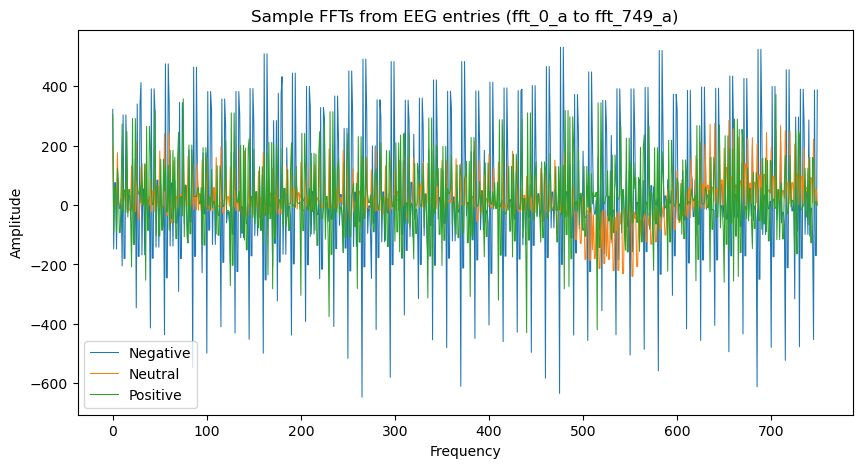

In [5]:
# Plot random sample FFT data from the dataset for each label
sample_negative = data[data['label'] == 'NEGATIVE'].sample(1).iloc[0].loc['fft_0_a':'fft_749_a']
sample_neutral = data[data['label'] == 'NEUTRAL'].sample(1).iloc[0].loc['fft_0_a':'fft_749_a']
sample_positive = data[data['label'] == 'POSITIVE'].sample(1).iloc[0].loc['fft_0_a':'fft_749_a']

plt.figure(figsize=(10, 5))
plt.plot(range(len(sample_negative)), sample_negative, label="Negative", linewidth=0.75)
plt.plot(range(len(sample_neutral)), sample_neutral, label="Neutral", linewidth=0.75)
plt.plot(range(len(sample_positive)), sample_positive, label="Positive", linewidth=0.75)
plt.title("Sample FFTs from EEG entries (fft_0_a to fft_749_a)")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

In [6]:
data['label'].value_counts()

label
NEUTRAL     716
NEGATIVE    708
POSITIVE    708
Name: count, dtype: int64

## Data Preprocessing

For preprocessing, the data is split between a training and testing set and a label mapping is applied for a numeric classification.

In [7]:
label_mapping = {
    'NEGATIVE': 0,
    'NEUTRAL': 1,
    'POSITIVE': 2,
}

In [8]:
def preprocess_inputs(df):
    df = df.copy()
    
    df['label'] = df['label'].replace(label_mapping)  # Encode labels
    
    y = df['label'].copy()
    X = df.drop('label', axis=1).copy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=78)  # Split dataset
    
    return X_train, X_test, y_train, y_test

In [9]:
X_train, X_test, y_train, y_test = preprocess_inputs(data)

In [10]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (1705, 2548)
X_test: (427, 2548)
y_train: (1705,)
y_test: (427,)


## Data Modeling

### Data Model

The data modeling approach in this notebook uses a **Gated Recurrent Unit (GRU)** neural network architecture. GRUs are recurrent neural networks (RNN) that are well-suited for sequential data, such as EEG signals, as they can capture patterns and dependencies that emerge over time.

##### Architecture

1. **Input Layer**: The model input consists of extracted EEG features from the dataset. Each feature is treated as a timestep in the sequential data.

2. **GRU Layer**: A single GRU layer is used with a hidden size of 256.

3. **Flatten Layer**: The output of the GRU layer is flattened to prepare it for the fully connected layer.

4. **Dropout Layer**: A dropout layer with a probability of 0.5 is applied to prevent overfitting by randomly deactivating neurons during training.

5. **Fully Connected Layer**: A fully connected layer maps the flattened GRU output to the desired number of output classes (3 in this case: Negative, Neutral, and Positive).

6. **Softmax Output**: The final layer applies a softmax activation function through the cross entropy loss function to generate probabilities for each class.

In [11]:
class EmotionClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(EmotionClassifier, self).__init__()
        self.gru = nn.GRU(input_size=1, hidden_size=256, batch_first=True)  # input_size=1 since each feature is treated as a timestep
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(256 * input_dim, output_dim) 

    def forward(self, x):
        x, _ = self.gru(x)  # x shape: (batch, seq_len=input_dim=2548, hidden_size=256)
        x = self.flatten(x)  # Flatten to (batch, seq_len * hidden_size)
        x = self.dropout(x)
        x = self.fc(x)  # Output shape: (batch, output_dim=3)
        return x

input_dim = X_train.shape[1]  # Features = 2548
output_dim = 3  # 3 classes: Negative, Neutral, Positive

model = EmotionClassifier(input_dim=input_dim, output_dim=output_dim)
model = model.to(device)
model

EmotionClassifier(
  (gru): GRU(1, 256, batch_first=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=652288, out_features=3, bias=True)
)


### Training
- The model is trained using the **`CrossEntropyLoss`** function, which is suitable for multi-class classification problems.
- The **`Adam`** optimizer is used, with a dynamic learning rate starting at 0.001 and scheduled to half every 5 epochs as well as a weighted decay.
- Early stopping is added to prevent overfitting by halting the training if the validation loss does not improve for 5 consecutive epochs.

In [12]:
# Configure parameters
batch_size = 32
epochs = 50
lr = 0.001
weight_decay = 1e-5
early_stopping_patience = 5

In [13]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device)


# Reshape to match GRU input expectations (batch, seq_len=input_dim, features=1)
X_train_tensor = X_train_tensor.unsqueeze(-1)  # Reshape to (batch, seq_len=input_dim, features=1)
X_test_tensor = X_test_tensor.unsqueeze(-1)

# Split to validation set
X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor = train_test_split(X_train_tensor, y_train_tensor, train_size=0.8, random_state=78)


# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)

In [14]:
best_loss = float('inf')
patience_counter = 0

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # Decay LR by 0.5 every 5 epochs
criterion = nn.CrossEntropyLoss()

# Training loop
losses = []
accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    # Training phase
    model.train()
    epoch_loss = 0.0
    correct_train = 0
    total_train = 0
    
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}", position=0, leave=True) as pbar:
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += y_batch.size(0)
            correct_train += (predicted == y_batch).sum().item()
            
            pbar.update(1)
    
    scheduler.step()  # Update learning rate
    epoch_loss /= len(train_loader)  # Mean training loss
    accuracy = correct_train / total_train  # Training accuracy
    losses.append(epoch_loss)
    accuracies.append(accuracy)
    
    # Validation phase
    model.eval()
    epoch_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            val_outputs = model(X_val_batch)
            val_loss = criterion(val_outputs, y_val_batch)
            epoch_val_loss += val_loss.item()
            
            _, val_predicted = torch.max(val_outputs, 1)
            total_val += y_val_batch.size(0)
            correct_val += (val_predicted == y_val_batch).sum().item()
    
    epoch_val_loss /= len(val_loader)  # Mean validation loss
    val_accuracy = correct_val / total_val  # Validation accuracy
    val_losses.append(epoch_val_loss)
    val_accuracies.append(val_accuracy)
    
    # Print metrics for the epoch
    print(f"Epoch {epoch+1}/{epochs}, "
          f"Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, "
          f"LR: {scheduler.get_last_lr()[0]:.6f}")
    
    # Early stopping
    if epoch_val_loss < best_loss:
        best_loss = epoch_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

Epoch 1/50:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 1/50, Loss: 20.5260, Accuracy: 0.7896, Val Loss: 3.7441, Val Accuracy: 0.9326, LR: 0.001000


Epoch 2/50:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 2/50, Loss: 3.3161, Accuracy: 0.9091, Val Loss: 2.7541, Val Accuracy: 0.9531, LR: 0.001000


Epoch 3/50:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 3/50, Loss: 4.7729, Accuracy: 0.9186, Val Loss: 2.9881, Val Accuracy: 0.9326, LR: 0.001000


Epoch 4/50:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 4/50, Loss: 1.7745, Accuracy: 0.9538, Val Loss: 1.2772, Val Accuracy: 0.9619, LR: 0.001000


Epoch 5/50:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 5/50, Loss: 0.5472, Accuracy: 0.9824, Val Loss: 1.6421, Val Accuracy: 0.9707, LR: 0.000500


Epoch 6/50:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 6/50, Loss: 0.3298, Accuracy: 0.9905, Val Loss: 0.8873, Val Accuracy: 0.9765, LR: 0.000500


Epoch 7/50:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 7/50, Loss: 0.2036, Accuracy: 0.9897, Val Loss: 2.2942, Val Accuracy: 0.9677, LR: 0.000500


Epoch 8/50:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 8/50, Loss: 0.0702, Accuracy: 0.9934, Val Loss: 1.2953, Val Accuracy: 0.9853, LR: 0.000500


Epoch 9/50:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 9/50, Loss: 0.0303, Accuracy: 0.9963, Val Loss: 1.5341, Val Accuracy: 0.9677, LR: 0.000500


Epoch 10/50:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 10/50, Loss: 0.1465, Accuracy: 0.9927, Val Loss: 1.4699, Val Accuracy: 0.9648, LR: 0.000250


Epoch 11/50:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 11/50, Loss: 0.0235, Accuracy: 0.9978, Val Loss: 0.8131, Val Accuracy: 0.9765, LR: 0.000250


Epoch 12/50:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 12/50, Loss: 0.0061, Accuracy: 0.9985, Val Loss: 1.0660, Val Accuracy: 0.9765, LR: 0.000250


Epoch 13/50:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 13/50, Loss: 0.0000, Accuracy: 1.0000, Val Loss: 0.9727, Val Accuracy: 0.9765, LR: 0.000250


Epoch 14/50:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 14/50, Loss: 0.0000, Accuracy: 1.0000, Val Loss: 0.9717, Val Accuracy: 0.9765, LR: 0.000250


Epoch 15/50:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 15/50, Loss: 0.0000, Accuracy: 1.0000, Val Loss: 0.9716, Val Accuracy: 0.9765, LR: 0.000125


Epoch 16/50:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 16/50, Loss: 0.0000, Accuracy: 1.0000, Val Loss: 0.9717, Val Accuracy: 0.9765, LR: 0.000125
Early stopping triggered.


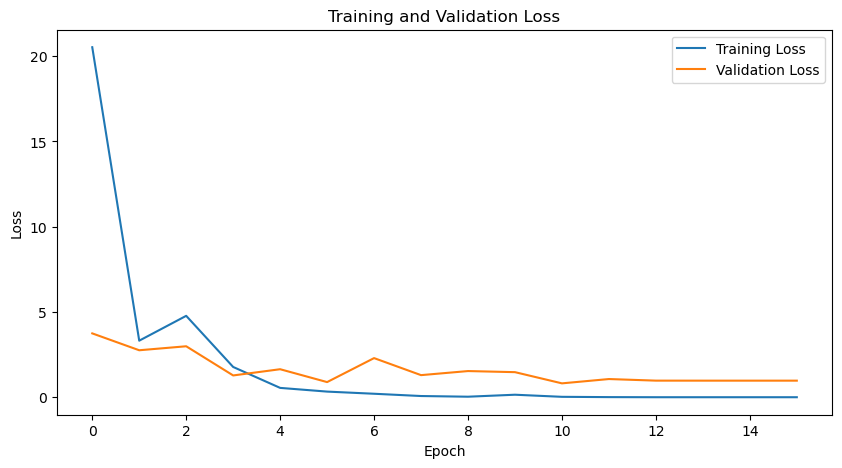

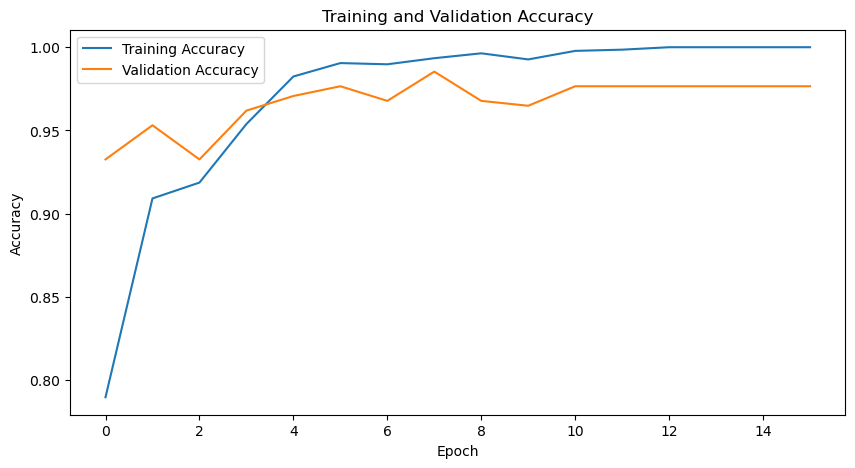

In [15]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

In [16]:
# Load the best model
model.load_state_dict(torch.load("best_model.pth"))

<All keys matched successfully>

In [17]:
# OPTIONAL: Save the model file for future use
model_file = "./models/emotion_classifier_model.pth"
torch.save(model, model_file)
print("Model saved as 'emotion_classifier_model.pth'")

Model saved as 'emotion_classifier_model.pth'


In [ ]:
# OPTIONAL: Load a locally saved model file
model_file = "./models/emotion_classifier_model.pth"
model = torch.load(model_file, weights_only=False)

## Results

In [18]:
# Evaluate the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    total = y_test_tensor.size(0)
    correct = (predicted == y_test_tensor).sum().item()

model_acc = correct / total
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

Test Accuracy: 96.956%


In [19]:
# Generate predicted class labels
y_pred = torch.argmax(model(X_test_tensor), axis=1).cpu().numpy()

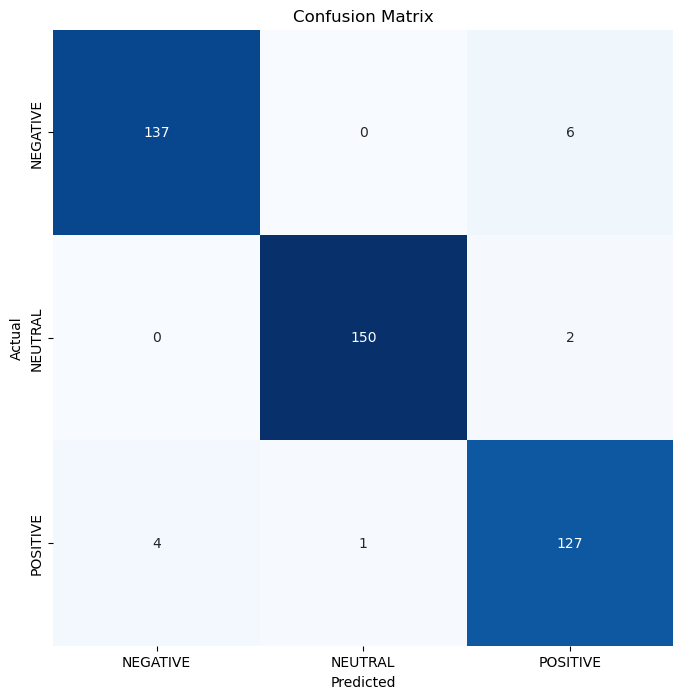

In [20]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(3) + 0.5, label_mapping.keys())
plt.yticks(np.arange(3) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [21]:
# Classification report
clr = classification_report(y_test, y_pred, target_names=label_mapping.keys())
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.97      0.96      0.96       143
     NEUTRAL       0.99      0.99      0.99       152
    POSITIVE       0.94      0.96      0.95       132

    accuracy                           0.97       427
   macro avg       0.97      0.97      0.97       427
weighted avg       0.97      0.97      0.97       427

